# Chapter 3. Classification

In Chapter 1 it was mentioned that the most common supervised learning tasks are regression (predicting values) and classification (predicting classes).

In Chapter 2 it was explored a regression task, predicting housing values, using various algorithms such as Linear Regression, Decision Trees, and Random Forests (which will be explained in further detail in later chapters). Now classification systems will be covered.

In [5]:
# Setup

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import warnings

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

The text describes the MNIST dataset, which consists of 70,000 small images of handwritten digits. The dataset is labeled with the corresponding digits. It is widely used in the field of Machine Learning and is often considered the "hello world" of ML. Many researchers and learners use this dataset to test the performance of new classification algorithms and it is a common dataset for anyone studying Machine Learning.

Scikit-Learn provides many helper functions to download popular
datasets. MNIST is one of them. The following code fetches the MNIST
dataset

In [6]:
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Scikit-Learn datasets follow a consistent dictionary structure. The structure includes a "DESCR" key providing a description of the dataset, a "data" key containing an array with instances and features, and a "target" key containing an array with corresponding labels.

In [7]:
# Looking at the data

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

The dataset consists of 70,000 images, where each image has 784 features. The images are 28x28 pixels, and each feature represents the intensity of a pixel ranging from 0 (white) to 255 (black). To visualize a digit from the dataset, you can retrieve the feature vector of an instance, reshape it into a 28x28 array, and display it using Matplotlib's imshow() function.

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [10]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

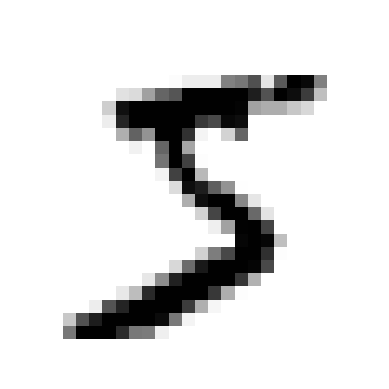

In [11]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [12]:
# Label
y[0]

'5'

In [13]:
# Changing label from string to integer

y = y.astype(np.uint8)

In [14]:
# Creating a test set

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Saving figure more_digits_plot


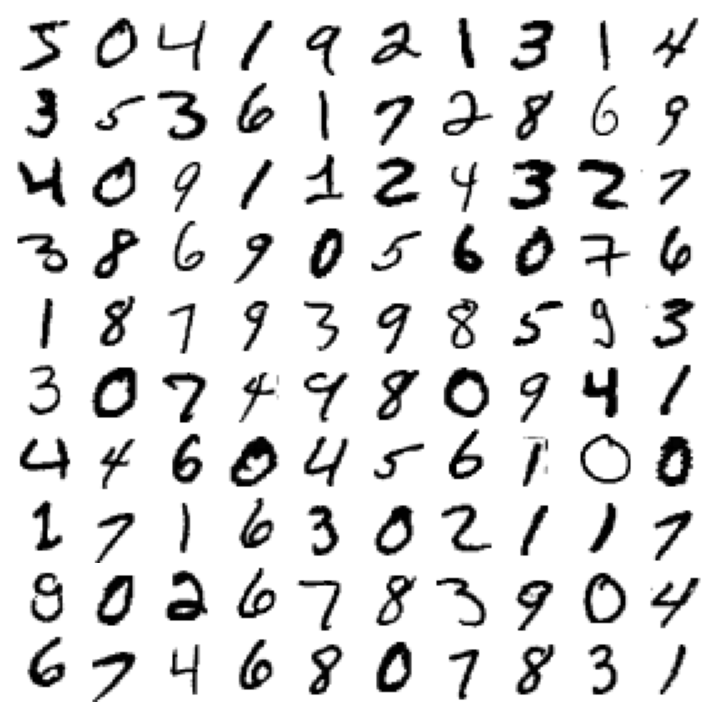

In [37]:
# extra code – this cell generates and saves Figure 3–2
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

## Training a Binary Classifier

The task at hand is to create a binary classifier that can identify the digit 5 from other digits (not-5). This classifier will distinguish between two classes: 5 and not-5. The next step involves creating the target vectors for this classification task.

In [15]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

To train a classifier, the Stochastic Gradient Descent (SGD) classifier is a good starting point. Scikit-Learn provides the SGDClassifier class for this purpose. One advantage of this classifier is its efficiency in handling large datasets. This efficiency is achieved because SGD processes training instances independently, making it suitable for online learning as well. To train the SGDClassifier, you can create an instance of the class and train it using the entire training set.

In [16]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [18]:
# Detecting images of 5
sgd_clf.predict([some_digit])

array([ True])

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

## Performance Measues

Evaluating a classifier is more complex than evaluating a regressor, and this chapter will focus on discussing this topic extensively. There are numerous performance measures available, and the chapter will introduce various new concepts and acronyms. One effective method for evaluating a model is to use cross-validation.

In certain situations, you might require more control over the cross-validation process than what is readily available in Scikit-Learn. In such cases, you can implement cross-validation manually. The provided code performs a similar task as Scikit-Learn's cross_val_score() function and produces the same output.

In [20]:
# Measuring Accuracy Using Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


The StratifiedKFold class is used for performing stratified sampling, ensuring that the folds generated contain a proportional representation of each class. In each iteration, the code clones the classifier, trains it on the training folds, and makes predictions on the test fold. The number of correct predictions is then counted, and the ratio of correct predictions is outputted as a result.

To evaluate the SGDClassifier model, we can use the cross_val_score() function with K-fold cross-validation. In this case, we will use three folds, meaning the training set will be split into three parts. The model will be trained on two of the folds and evaluated on the remaining fold. This process will be repeated for each fold, allowing us to assess the model's performance on different subsets of the data.

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [24]:
# simple and naive classifier that classifies every image as "not-5"
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):

    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [25]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

### Confusion Matrix

A more effective method for evaluating the performance of a classifier is by examining the confusion matrix. This involves counting the number of times instances from one class are classified as another class. For example, to determine how many times the classifier confused images of the digit 5 with the digit 3, you would check the cell in the fifth row and third column of the confusion matrix.

To calculate the confusion matrix, you need a set of predictions that can be compared to the actual target values. While you could make predictions on the test set, it is advisable to keep the test set untouched until the end of your project, when you have a final classifier ready for deployment. Instead, you can utilize the cross_val_predict() function.

In [28]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In a confusion matrix, each row represents the actual class and each column represents the predicted class. For example, in the first row, which represents non-5 images (negative class), 53892 instances were correctly classified as non-5s (true negatives), while 687 instances were wrongly classified as 5s (false positives). In the second row, which represents images of 5s (positive class), 1891 instances were wrongly classified as non-5s (false negatives), while 3530 instances were correctly classified as 5s (true positives). 

A perfect classifier would only have true positives and true negatives, meaning its confusion matrix would have non-zero values only on its main diagonal.

### Precision and Recall

The confusion matrix provides comprehensive information, but sometimes a more concise metric is preferred. One such metric is the precision of the classifier, which measures the accuracy of positive predictions. 

The precision is calculated using the number of true positives (TP) and false positives (FP). Achieving perfect precision can be trivial by making a single positive prediction that is correct, but this approach would disregard all but one positive instance, making it impractical. Therefore, precision is typically used in conjunction with another metric called recall, sensitivity, or true positive rate (TPR). 

Recall represents the ratio of positive instances correctly detected by the classifier.

In [30]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [32]:
recall_score(y_train_5, y_train_pred)


0.6511713705958311

The F score is a metric that combines precision and recall into a single value. It is commonly used when comparing two classifiers. The F score is calculated as the harmonic mean of precision and recall, giving more weight to low values. This means that a classifier will only receive a high F score if both precision and recall are high. Unlike the regular mean, which treats all values equally, the harmonic mean emphasizes the importance of balancing precision and recall.

In [34]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-off

The SGDClassifier makes classification decisions by computing a score for each instance based on a decision function. 

This score is compared to a threshold to determine the class assignment. In a visualization, digits are sorted from the lowest score on the left to the highest score on the right. By adjusting the threshold, the classifier's precision and recall can be modified. 

Raising the threshold improves precision but decreases recall, while lowering the threshold increases recall but reduces precision. The trade-off between precision and recall depends on the chosen threshold.

In [38]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [39]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [40]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image
actually represents a 5, and the classifier detects it when the threshold is 0,
but it misses it when the threshold is increased to 8,000.

In [49]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [50]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

In [51]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

Saving figure precision_recall_vs_threshold_plot


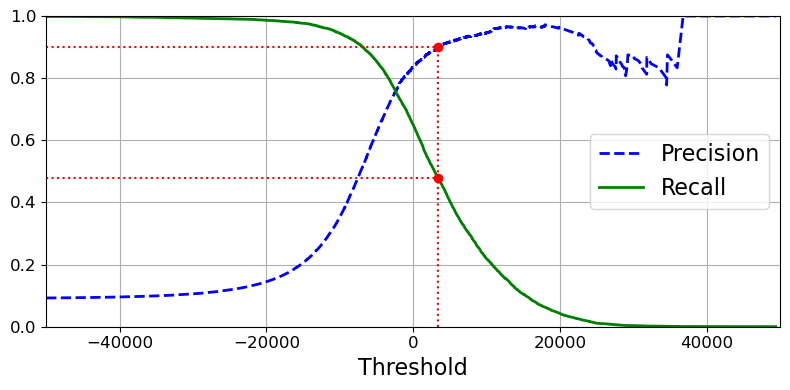

In [52]:
plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [53]:
(y_train_pred == (y_scores > 0)).all()


True

Saving figure precision_vs_recall_plot


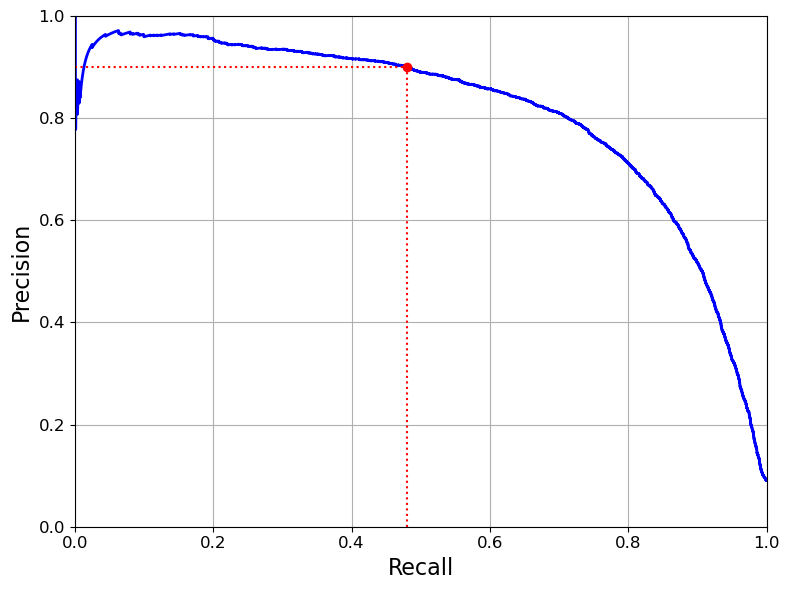

In [54]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [55]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


In [56]:
threshold_90_precision


3370.0194991439594

In [57]:
y_train_pred_90 = (y_scores >= threshold_90_precision)


In [58]:
precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

In [59]:
recall_score(y_train_5, y_train_pred_90)


0.4799852425751706

### The ROC Curve

The ROC curve is a commonly used tool for binary classifiers. It is similar to the precision/recall curve but instead plots the true positive rate (recall) against the false positive rate (FPR). The FPR represents the ratio of negative instances incorrectly classified as positive, while the true negative rate (TNR) represents the ratio of negative instances correctly classified as negative (also known as specificity). 

The ROC curve therefore plots sensitivity (recall) against 1 - specificity. To plot the ROC curve, the roc_curve() function is used to calculate the TPR and FPR for different threshold values.

In [60]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


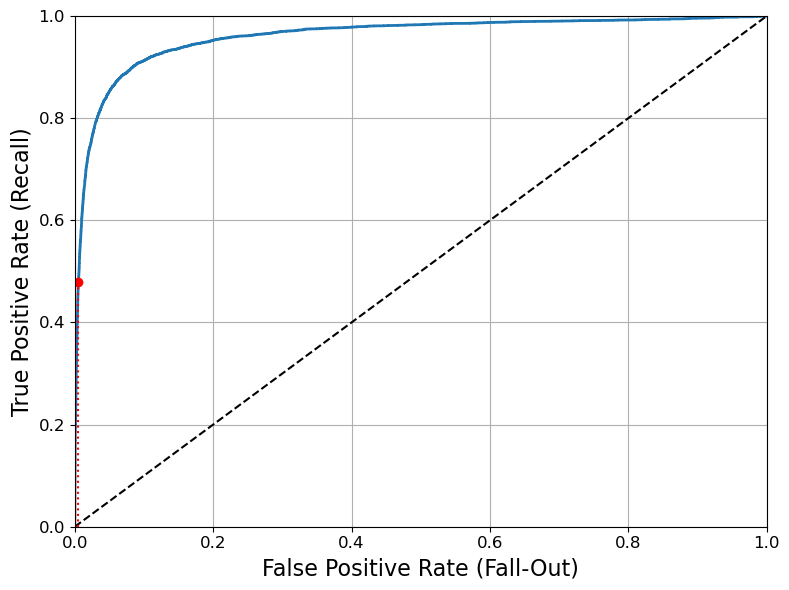

In [61]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [62]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [63]:

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [64]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


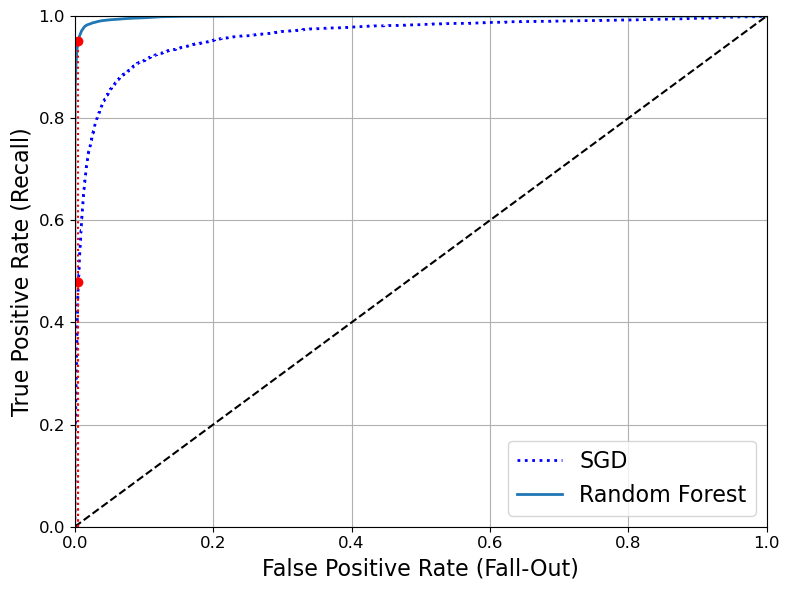

In [65]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [66]:
roc_auc_score(y_train_5, y_scores_forest)


0.9983436731328145

In [67]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [68]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

### Multiclass Classification

Multiclass classifiers can distinguish between more than two classes, while binary classifiers can only distinguish between two classes. Certain algorithms can handle multiple classes inherently, while others are strictly binary classifiers. However, there are strategies to perform multiclass classification using multiple binary classifiers.



One approach is the one-versus-the-rest (OvR) strategy, where you train 10 binary classifiers, each dedicated to detecting a specific digit (0 to 9). To classify an image, you obtain the decision scores from each classifier and select the class with the highest score. Another strategy is the one-versus-one (OvO) strategy, where you train a binary classifier for every pair of digits. This requires training N × (N – 1) / 2 classifiers, meaning 45 binary classifiers for the MNIST problem. The winning class is determined by running the image through all 45 classifiers and tallying the most wins.



The choice between OvR and OvO depends on the algorithm and the size of the training set. Some algorithms, like Support Vector Machine classifiers, scale poorly with large training sets, favoring the faster training of multiple classifiers on smaller sets (OvO). However, most binary classification algorithms prefer the OvR strategy.



Scikit-Learn automatically detects the multiclass nature of the task and applies either OvR or OvO when a binary classification algorithm is used for a multiclass classification task. For example, the sklearn.svm.SVC class in Chapter 5 can be used for multiclass classification.

In [69]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [70]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [71]:
np.argmax(some_digit_scores)


5

In [72]:
svm_clf.classes_


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [73]:
svm_clf.classes_[5]


5

In [74]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [75]:
len(ovr_clf.estimators_)


10

In [76]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [77]:
sgd_clf.decision_function([some_digit])


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [78]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

### Error Analysis

In a hypothetical real project scenario, following a Machine Learning project checklist would be the next step. This would involve exploring data preparation options, trying out multiple models, shortlisting the best ones, and fine-tuning their hyperparameters using GridSearchCV. In this specific context, assuming a promising model has been found, the focus shifts to finding ways to improve it by analyzing the types of errors it makes. To begin this analysis, the confusion matrix is examined. Predictions are made using the cross_val_predict() function, and then the confusion_matrix() function is called, similar to what was done earlier.

In [82]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [ ]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


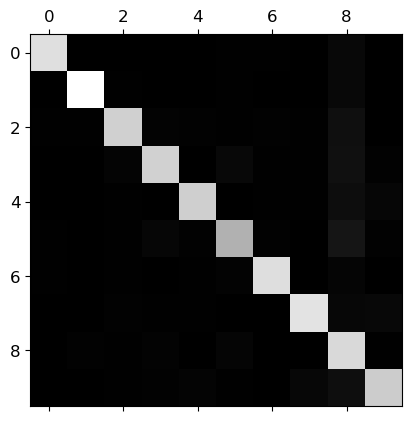

In [83]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [84]:

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


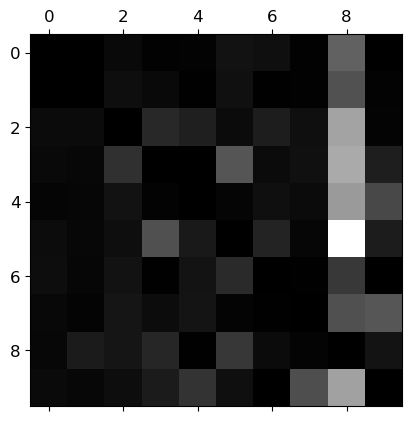

In [85]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

In [87]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure error_analysis_digits_plot


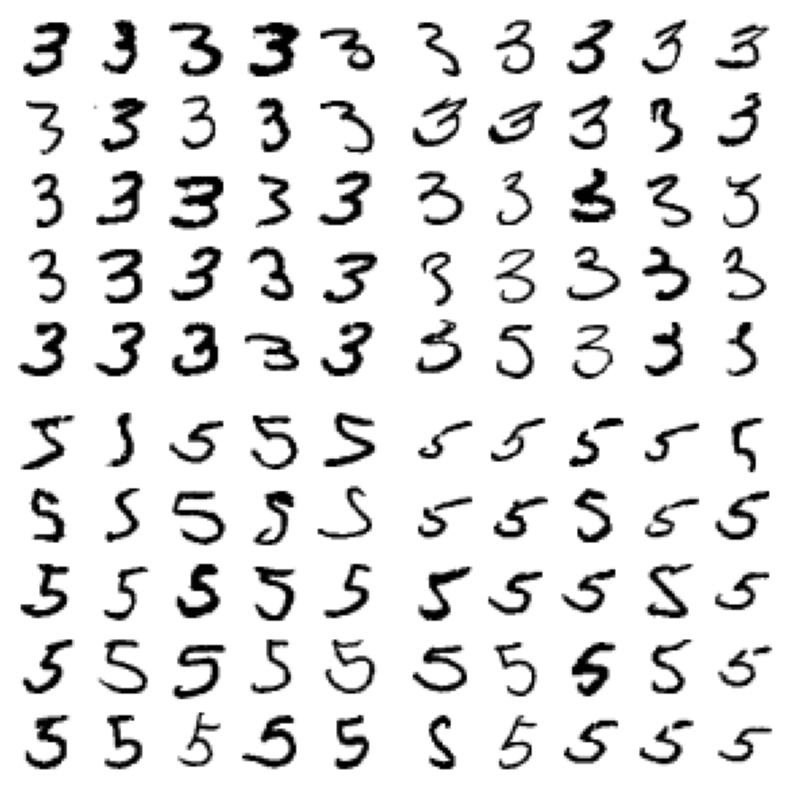

In [88]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

The left side of the image displays two blocks of 5x5 digits classified as 3s, while the right side shows two blocks of 5x5 digits classified as 5s. Some misclassified digits are poorly written, making it challenging for both the classifier and humans to correctly identify them. 
However, most misclassified images appear to be clear mistakes, and it is difficult to understand why the classifier made those errors. The reason behind this is the use of a simple linear model called SGDClassifier, which assigns weights to each pixel and calculates a score for each class based on the weighted pixel intensities. Since the difference between 3s and 5s is minimal, the model easily confuses them.

The primary distinction between 3s and 5s lies in the position of the small connecting line between the top line and the bottom arc. If the junction is slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is highly sensitive to image shifting and rotation. To minimize confusion between 3s and 5s, it would be beneficial to preprocess the images, ensuring they are well-centered and not excessively rotated. This preprocessing step is likely to reduce other classification errors as well.

### Multilabel Classification

Traditionally, classifiers assign a single class to each instance. However, in certain cases, it may be desirable for a classifier to output multiple classes for a single instance. For instance, in face recognition, if there are multiple people recognized in a picture, the classifier should attach a tag for each person it identifies. For example, if the classifier has been trained to recognize Alice, Bob, and Charlie, and it is presented with a picture containing Alice and Charlie, it should output [1, 0, 1] (indicating "Alice yes, Bob no, Charlie yes"). This type of classification system, which generates multiple binary tags, is referred to as a multilabel classification system.

Although we won't delve into face recognition specifically, let's consider a simpler example for the purpose of illustration.

In [89]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [90]:
knn_clf.predict([some_digit])


array([[False,  True]])

In [94]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In a multilabel classification scenario, it is often assumed that all labels are equally important. However, this assumption may not hold true in certain cases. For example, if there are significantly more pictures of Alice compared to Bob or Charlie, it might be necessary to assign more weight to the classifier's score for pictures of Alice. One approach to address this is to assign each label a weight equal to its support, which refers to the number of instances with that particular target label. This can be achieved by setting the parameter "average" to "weighted" in the code.

### Multioutput Classification

The classification task called multioutput-multiclass classification, or multioutput classification, is an extension of multilabel classification. In multioutput classification, each label can have multiple possible values, unlike the binary nature of multilabel classification.

To demonstrate this, let's consider the example of building a system that removes noise from images. This system takes a noisy digit image as input and aims to produce a clean digit image as output. The clean image is represented as an array of pixel intensities, similar to the MNIST dataset. In this case, the classifier's output is considered multilabel, with one label per pixel, and each label can have multiple values representing the range of pixel intensities from 0 to 255. Therefore, this example illustrates a multioutput classification system.

In [91]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


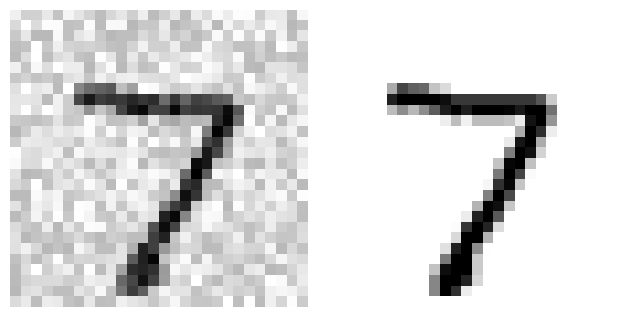

In [92]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


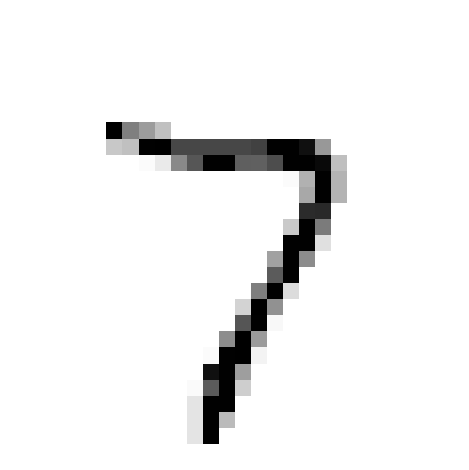

In [93]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

Looks close enough to the target! This concludes our tour of classification.
You should now know how to select good metrics for classification tasks,
pick the appropriate precision/recall trade-off, compare classifiers, and
more generally build good classification systems for a variety of tasks.